In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import librosa
from tqdm.notebook import tqdm 
from sklearn.preprocessing import LabelEncoder

In [58]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf

In [4]:
speech_path = 'Audio_Speech_Actors'
song_path = 'Audio_Song_Actors'  

audio_files_speech = []
for root, _, files in os.walk(speech_path):
    for file in files:
        if file.endswith(".wav"):
            audio_files_speech.append(os.path.join(root, file))

print(f"Total speech files: {len(audio_files_speech)}")

Total speech files: 1440


In [5]:
audio_files_song = []

for root, _, files in os.walk(song_path):
    for file in files:
        if file.endswith(".wav"):
            audio_files_song.append(os.path.join(root, file))

print(f"Total song files: {len(audio_files_song)}")

Total song files: 1012


In [6]:
audio_files=audio_files_speech+audio_files_song
print(len(audio_files))

2452


In [7]:
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

In [8]:
def extract_emotion(filename):
    parts = filename.split('-')
    emotion_code = parts[2]
    return emotion_map.get(emotion_code, "unknown")

In [9]:
df = pd.DataFrame(audio_files, columns=['path'])
df['filename'] = df['path'].apply(lambda x: os.path.basename(x))
df['emotion'] = df['filename'].apply(extract_emotion)

print(df['emotion'].value_counts())
df.head()

emotion
calm         376
happy        376
sad          376
angry        376
fearful      376
disgust      192
surprised    192
neutral      188
Name: count, dtype: int64


,path,filename,emotion
0,Audio_Speech_Actors\Actor_01\03-01-01-01-01-01...,03-01-01-01-01-01-01.wav,neutral
1,Audio_Speech_Actors\Actor_01\03-01-01-01-01-02...,03-01-01-01-01-02-01.wav,neutral
2,Audio_Speech_Actors\Actor_01\03-01-01-01-02-01...,03-01-01-01-02-01-01.wav,neutral
3,Audio_Speech_Actors\Actor_01\03-01-01-01-02-02...,03-01-01-01-02-02-01.wav,neutral
4,Audio_Speech_Actors\Actor_01\03-01-02-01-01-01...,03-01-02-01-01-01-01.wav,calm


In [10]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['emotion'],
    random_state=42
)

print(f"Train size: {len(train_df)} | Validation size: {len(val_df)}")

Train size: 1961 | Validation size: 491


In [12]:
def extract_features(file_path, sr=22050, duration=3, n_mfcc=40):
    try:
        audio, _ = librosa.load(file_path, sr=sr, duration=duration, res_type='kaiser_fast')
        
        if len(audio) < sr * duration:
            pad_width = sr * duration - len(audio)
            audio = np.pad(audio, (0, pad_width))

        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        mfccs = np.mean(mfccs.T, axis=0)  

        return mfccs
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros(n_mfcc)

In [13]:
def build_feature_dataset(df):
    features = []
    labels = []

    for i, row in tqdm(df.iterrows(), total=len(df)):
        mfcc_feat = extract_features(row['path'])  
        features.append(mfcc_feat)
        labels.append(row['emotion'])              

    return np.array(features), np.array(labels)

In [16]:
pip install resampy

   ---------------------------------------- 0.0/3.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/3.1 MB ? eta -:--:--
   --- ------------------------------------ 0.3/3.1 MB ? eta -:--:--
   --- ------------------------------------ 0.3/3.1 MB ? eta -:--:--
   --- ------------------------------------ 0.3/3.1 MB ? eta -:--:--
   --- ------------------------------------ 0.3/3.1 MB ? eta -:--:--
   ------ --------------------------------- 0.5/3.1 MB 357.1 kB/s eta 0:00:08
   ------ --------------------------------- 0.5/3.1 MB 357.1 kB/s eta 0:00:08
   ------ --------------------------------- 0.5/3.1 MB 357.1 kB/s eta 0:00:08
   ------ --------------------------------- 0.5/3.1 MB 357.1 kB/s eta 0:00:08
   ---------- ----------------------------- 0.8/3.1 MB 335.4 kB/s eta 0:00:07
   ---------- ----------------------------- 0.8/3.1 MB 335


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
X_train, y_train = build_feature_dataset(train_df)
X_val, y_val = build_feature_dataset(val_df)

  0%|          | 0/1961 [00:00<?, ?it/s]

  0%|          | 0/491 [00:00<?, ?it/s]

In [15]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

# Save for inverse transform later
emotion_classes = le.classes_

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# One-hot encode labels
num_classes = len(np.unique(y_train_encoded))
y_train_cat = to_categorical(y_train_encoded, num_classes)
y_val_cat = to_categorical(y_val_encoded, num_classes)

model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(
    X_train, y_train_cat,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val_cat),
    callbacks=[],
    verbose=1
)


Epoch 1/50
62/62 [==============================] - 3s 15ms/step - loss: 24.1469 - accuracy: 0.1372 - val_loss: 2.0772 - val_accuracy: 0.1527
Epoch 2/50
62/62 [==============================] - 0s 7ms/step - loss: 2.5041 - accuracy: 0.1407 - val_loss: 2.0703 - val_accuracy: 0.1527
Epoch 3/50
62/62 [==============================] - 0s 7ms/step - loss: 2.1896 - accuracy: 0.1540 - val_loss: 2.0640 - val_accuracy: 0.1527
Epoch 4/50
62/62 [==============================] - 0s 8ms/step - loss: 2.1094 - accuracy: 0.1443 - val_loss: 2.0586 - val_accuracy: 0.1527
Epoch 5/50
62/62 [==============================] - 1s 8ms/step - loss: 2.1065 - accuracy: 0.1525 - val_loss: 2.0543 - val_accuracy: 0.1527
Epoch 6/50
62/62 [==============================] - 0s 8ms/step - loss: 2.0703 - accuracy: 0.1591 - val_loss: 2.0508 - val_accuracy: 0.1527
Epoch 7/50
62/62 [==============================] - 0s 8ms/step - loss: 2.0778 - accuracy: 0.1530 - val_loss: 2.0475 - val_accuracy: 0.1527
Epoch 8/50
62/62 [

16/16 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

       angry       0.15      1.00      0.27        75
        calm       0.00      0.00      0.00        75
     disgust       0.00      0.00      0.00        39
     fearful       0.00      0.00      0.00        75
       happy       0.00      0.00      0.00        75
     neutral       0.00      0.00      0.00        38
         sad       0.00      0.00      0.00        75
   surprised       0.00      0.00      0.00        39

    accuracy                           0.15       491
   macro avg       0.02      0.12      0.03       491
weighted avg       0.02      0.15      0.04       491



c:\softwares\python 3.8\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\softwares\python 3.8\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\softwares\python 3.8\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


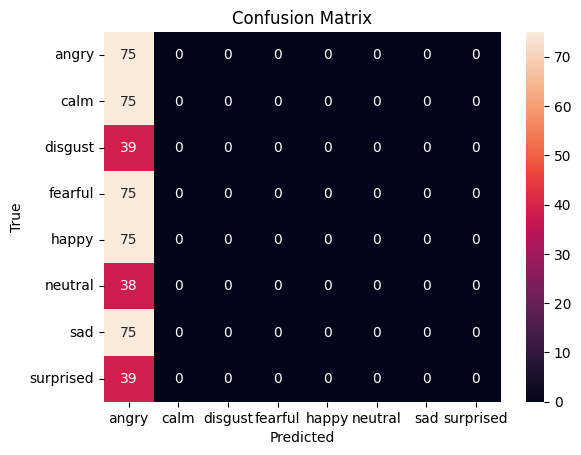

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_val_encoded, y_pred_classes, target_names=emotion_classes))

cm = confusion_matrix(y_val_encoded, y_pred_classes)

sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotion_classes, yticklabels=emotion_classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [19]:
def extract_mfcc_2d(file_path, sr=22050, duration=3, n_mfcc=40):
    audio, _ = librosa.load(file_path, sr=sr, duration=duration)
    
    # Pad short clips
    if len(audio) < sr * duration:
        pad_width = sr * duration - len(audio)
        audio = np.pad(audio, (0, pad_width))

    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    
    # Shape: (n_mfcc, time_frames), e.g., (40, 130)
    return mfcc

In [20]:
def build_cnn_dataset(df):
    features = []
    labels = []

    for i, row in tqdm(df.iterrows(), total=len(df)):
        mfcc = extract_mfcc_2d(row['path'])  # shape (40, ~130)
        features.append(mfcc)
        labels.append(row['emotion'])

    return np.array(features), np.array(labels)

In [21]:
X_train, y_train = build_cnn_dataset(train_df)
X_val, y_val = build_cnn_dataset(val_df)

  0%|          | 0/1961 [00:00<?, ?it/s]

  0%|          | 0/491 [00:00<?, ?it/s]

In [22]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Normalize (per sample)
X_train = X_train[..., np.newaxis]  # (samples, 40, time_steps, 1)
X_val = X_val[..., np.newaxis]

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

y_train_cat = to_categorical(y_train_enc)
y_val_cat = to_categorical(y_val_enc)

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

input_shape = X_train.shape[1:]  # (40, time_steps, 1)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')
])


In [24]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,
    batch_size=32
)


Epoch 1/50
62/62 [==============================] - 23s 336ms/step - loss: 3.4664 - accuracy: 0.1805 - val_loss: 1.9932 - val_accuracy: 0.2118
Epoch 2/50
62/62 [==============================] - 21s 331ms/step - loss: 2.0200 - accuracy: 0.1984 - val_loss: 1.9336 - val_accuracy: 0.2138
Epoch 3/50
62/62 [==============================] - 21s 335ms/step - loss: 1.9638 - accuracy: 0.2213 - val_loss: 1.9028 - val_accuracy: 0.2077
Epoch 4/50
62/62 [==============================] - 21s 332ms/step - loss: 1.9040 - accuracy: 0.2285 - val_loss: 1.8124 - val_accuracy: 0.2892
Epoch 5/50
62/62 [==============================] - 21s 332ms/step - loss: 1.8620 - accuracy: 0.2499 - val_loss: 1.9084 - val_accuracy: 0.2790
Epoch 6/50
62/62 [==============================] - 21s 333ms/step - loss: 1.8254 - accuracy: 0.2693 - val_loss: 1.7051 - val_accuracy: 0.3401
Epoch 7/50
62/62 [==============================] - 20s 330ms/step - loss: 1.7734 - accuracy: 0.2830 - val_loss: 1.6987 - val_accuracy: 0.3727

16/16 [==============================] - 1s 69ms/step
              precision    recall  f1-score   support

       angry       0.84      0.85      0.85        75
        calm       0.82      0.55      0.66        75
     disgust       0.40      0.69      0.51        39
     fearful       0.66      0.65      0.66        75
       happy       0.68      0.68      0.68        75
     neutral       0.00      0.00      0.00        38
         sad       0.37      0.57      0.45        75
   surprised       0.52      0.44      0.47        39

    accuracy                           0.59       491
   macro avg       0.54      0.55      0.53       491
weighted avg       0.59      0.59      0.58       491



c:\softwares\python 3.8\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\softwares\python 3.8\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\softwares\python 3.8\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


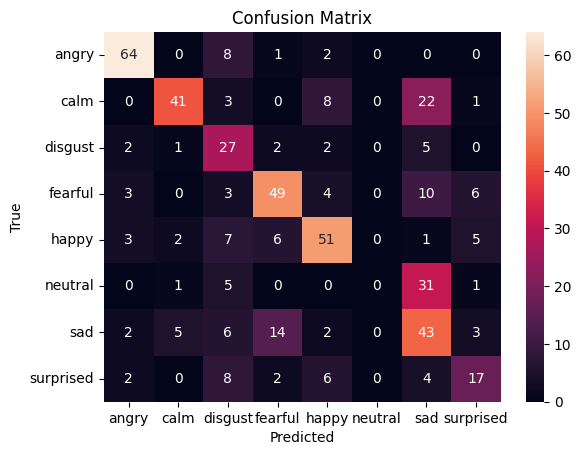

In [25]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)

print(classification_report(y_val_enc, y_pred_labels, target_names=le.classes_))

cm = confusion_matrix(y_val_enc, y_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [26]:
train_df_filtered = train_df[train_df['emotion'] != 'neutral']
val_df_filtered = val_df[val_df['emotion'] != 'neutral']

In [28]:
X_train, y_train = build_cnn_dataset(train_df_filtered)
X_val, y_val = build_cnn_dataset(val_df_filtered)

# Add channel dimension
X_train = X_train[..., np.newaxis]  # shape: (samples, 40, time_steps, 1)
X_val = X_val[..., np.newaxis]


  0%|          | 0/1811 [00:00<?, ?it/s]

  0%|          | 0/453 [00:00<?, ?it/s]

In [36]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
num_classes = len(le.classes_)

y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_val_cat = to_categorical(y_val_enc, num_classes=num_classes)
# Save for prediction later
emotion_classes = le.classes_


In [37]:
num_classes = len(np.unique(y_train_enc))
print("Number of classes:", num_classes)  # Should be 7

Number of classes: 7


In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_flat = X_train.reshape(len(X_train), -1)
X_val_flat = X_val.reshape(len(X_val), -1)

X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled = scaler.transform(X_val_flat)

# Reshape back to original CNN input shape
X_train = X_train_scaled.reshape(X_train.shape)
X_val = X_val_scaled.reshape(X_val.shape)

In [39]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]

In [40]:
input_shape = X_train.shape[1:]  # (40, time_steps, 1)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])


In [42]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
57/57 [==============================] - 23s 366ms/step - loss: 2.7734 - accuracy: 0.2308 - val_loss: 7.1365 - val_accuracy: 0.2208 - lr: 0.0010
Epoch 2/50
57/57 [==============================] - 20s 355ms/step - loss: 1.6488 - accuracy: 0.3208 - val_loss: 18.4416 - val_accuracy: 0.1854 - lr: 0.0010
Epoch 3/50
57/57 [==============================] - 20s 360ms/step - loss: 1.5199 - accuracy: 0.3573 - val_loss: 19.0850 - val_accuracy: 0.1943 - lr: 0.0010
Epoch 4/50
57/57 [==============================] - 20s 357ms/step - loss: 1.4176 - accuracy: 0.4097 - val_loss: 14.2468 - val_accuracy: 0.2185 - lr: 0.0010
Epoch 5/50
57/57 [==============================] - 21s 360ms/step - loss: 1.3170 - accuracy: 0.4473 - val_loss: 7.7602 - val_accuracy: 0.3223 - lr: 5.0000e-04
Epoch 6/50
57/57 [==============================] - 21s 362ms/step - loss: 1.2077 - accuracy: 0.4876 - val_loss: 3.6795 - val_accuracy: 0.3731 - lr: 5.0000e-04
Epoch 7/50
57/57 [==============================] - 2

In [44]:
y_pred_probs = model.predict(X_val)

# Convert to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)

15/15 [==============================] - 1s 75ms/step


In [45]:
print(classification_report(y_val_enc, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

       angry       0.79      0.79      0.79        75
        calm       0.66      0.79      0.72        75
     disgust       0.49      0.49      0.49        39
     fearful       0.63      0.64      0.64        75
       happy       0.80      0.65      0.72        75
         sad       0.55      0.56      0.56        75
   surprised       0.65      0.62      0.63        39

    accuracy                           0.66       453
   macro avg       0.65      0.65      0.65       453
weighted avg       0.67      0.66      0.66       453



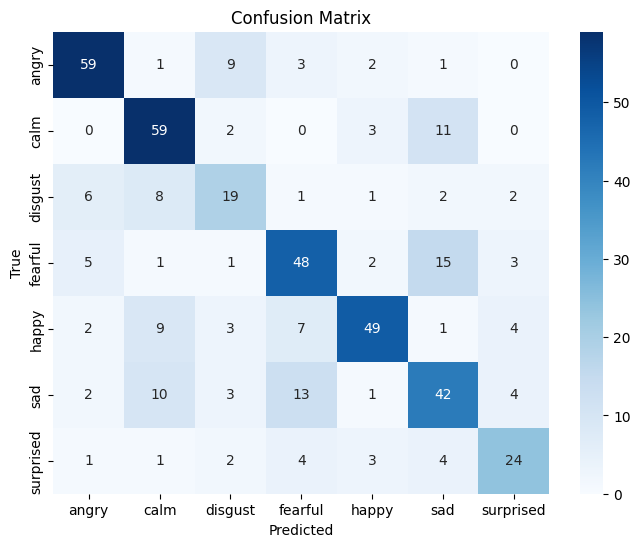

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val_enc, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [47]:
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for label, acc in zip(le.classes_, class_accuracy):
    print(f"{label}: {acc * 100:.2f}% accuracy")

angry: 78.67% accuracy
calm: 78.67% accuracy
disgust: 48.72% accuracy
fearful: 64.00% accuracy
happy: 65.33% accuracy
sad: 56.00% accuracy
surprised: 61.54% accuracy


In [ ]:
model.save("cnn_emotion_model.h5")

In [98]:
def extract_log_mel_spectrogram(file_path, sr=22050, duration=3, n_mels=128):
    try:
        audio, _ = librosa.load(file_path, sr=sr, duration=duration, res_type='kaiser_fast')

        # Pad short audio
        if len(audio) < sr * duration:
            pad_width = sr * duration - len(audio)
            audio = np.pad(audio, (0, pad_width))

        # Compute mel-spectrogram
        mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)

        # Convert to log scale
        log_mel = librosa.power_to_db(mel, ref=np.max)

        return log_mel  # shape: (n_mels, time_steps)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros((n_mels, 130))  # Fallback shape


In [100]:
def build_logmel_dataset(df):
    X, y = [], []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        features = extract_log_mel_spectrogram(row['path'])  # (128, time)
        X.append(features)
        y.append(row['emotion'])

    return np.array(X), np.array(y)


In [101]:
X_train, y_train = build_logmel_dataset(train_df)
X_val, y_val = build_logmel_dataset(val_df)


  0%|          | 0/1961 [00:00<?, ?it/s]

  0%|          | 0/491 [00:00<?, ?it/s]

In [102]:
# Add channel dimension
X_train = X_train[..., np.newaxis]  # shape: (samples, 128, time_steps, 1)
X_val = X_val[..., np.newaxis]


In [103]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

y_train_cat = to_categorical(y_train_enc)
y_val_cat = to_categorical(y_val_enc)


In [104]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

input_shape = X_train.shape[1:]

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(y_train_cat.shape[1], activation='softmax')
])


In [105]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/50
62/62 [==============================] - 88s 1s/step - loss: 4.4760 - accuracy: 0.1632 - val_loss: 4.0403 - val_accuracy: 0.1405 - lr: 0.0010
Epoch 2/50
62/62 [==============================] - 81s 1s/step - loss: 1.9875 - accuracy: 0.1892 - val_loss: 2.1350 - val_accuracy: 0.1242 - lr: 0.0010
Epoch 3/50
62/62 [==============================] - 84s 1s/step - loss: 1.9582 - accuracy: 0.2075 - val_loss: 2.6028 - val_accuracy: 0.2098 - lr: 0.0010
Epoch 4/50
62/62 [==============================] - 84s 1s/step - loss: 1.8895 - accuracy: 0.2371 - val_loss: 1.9913 - val_accuracy: 0.2403 - lr: 0.0010
Epoch 5/50
62/62 [==============================] - 85s 1s/step - loss: 1.8230 - accuracy: 0.2560 - val_loss: 2.7080 - val_accuracy: 0.1813 - lr: 0.0010
Epoch 6/50
62/62 [==============================] - 84s 1s/step - loss: 1.7962 - accuracy: 0.2565 - val_loss: 2.4030 - val_accuracy: 0.2118 - lr: 0.0010
Epoch 7/50
62/62 [==============================] - 84s 1s/step - loss: 1.7460 - a

16/16 [==============================] - 5s 274ms/step


c:\softwares\python 3.8\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\softwares\python 3.8\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\softwares\python 3.8\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       angry       0.30      0.76      0.44        75
        calm       0.17      0.03      0.05        75
     disgust       0.13      0.21      0.16        39
     fearful       0.24      0.45      0.31        75
       happy       0.28      0.16      0.20        75
     neutral       0.00      0.00      0.00        38
         sad       0.29      0.05      0.09        75
   surprised       0.03      0.03      0.03        39

    accuracy                           0.24       491
   macro avg       0.18      0.21      0.16       491
weighted avg       0.21      0.24      0.18       491



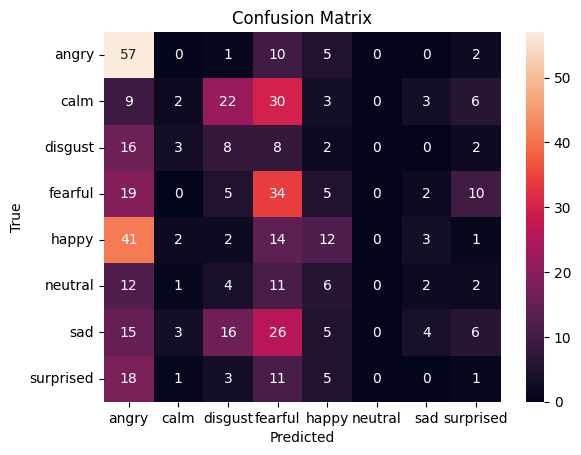

In [106]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_val_enc, y_pred_classes, target_names=le.classes_))

cm = confusion_matrix(y_val_enc, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [107]:
df_no_neutral = df[df['emotion'] != 'neutral'].copy().reset_index(drop=True)


In [108]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df_no_neutral,
    test_size=0.2,
    stratify=df_no_neutral['emotion'],
    random_state=42
)


In [109]:
def extract_log_mel_fixed(file_path, sr=22050, duration=3, n_mels=128, fixed_frames=128):
    try:
        audio, _ = librosa.load(file_path, sr=sr, duration=duration, res_type='kaiser_fast')

        if len(audio) < sr * duration:
            pad_width = sr * duration - len(audio)
            audio = np.pad(audio, (0, pad_width))

        mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, hop_length=512)
        log_mel = librosa.power_to_db(mel)

        # Force fixed shape
        if log_mel.shape[1] < fixed_frames:
            pad_width = fixed_frames - log_mel.shape[1]
            log_mel = np.pad(log_mel, ((0, 0), (0, pad_width)))
        else:
            log_mel = log_mel[:, :fixed_frames]

        return log_mel
    except Exception as e:
        print(f"Error with {file_path}: {e}")
        return np.zeros((n_mels, fixed_frames))


In [110]:
def build_dataset(df):
    X, y = [], []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        feat = extract_log_mel_fixed(row['path'])
        X.append(feat)
        y.append(row['emotion'])

    return np.array(X), np.array(y)


In [111]:
X_train, y_train = build_dataset(train_df)
X_val, y_val = build_dataset(val_df)


  0%|          | 0/1811 [00:00<?, ?it/s]

  0%|          | 0/453 [00:00<?, ?it/s]

In [112]:
# Add channel dimension
X_train = X_train[..., np.newaxis]  # (samples, 128, 128, 1)
X_val = X_val[..., np.newaxis]

# Encode labels
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

y_train_cat = to_categorical(y_train_enc)
y_val_cat = to_categorical(y_val_enc)


In [113]:
input_shape = X_train.shape[1:]  


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(y_train_cat.shape[1], activation='softmax')  
])

In [115]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]

In [116]:
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
57/57 [==============================] - 92s 2s/step - loss: 3.8020 - accuracy: 0.2352 - val_loss: 2.5400 - val_accuracy: 0.1611 - lr: 5.0000e-04
Epoch 2/50
57/57 [==============================] - 87s 2s/step - loss: 1.6593 - accuracy: 0.2943 - val_loss: 1.7421 - val_accuracy: 0.3179 - lr: 5.0000e-04
Epoch 3/50
57/57 [==============================] - 89s 2s/step - loss: 1.5852 - accuracy: 0.3263 - val_loss: 1.7221 - val_accuracy: 0.3024 - lr: 5.0000e-04
Epoch 4/50
57/57 [==============================] - 88s 2s/step - loss: 1.5276 - accuracy: 0.3479 - val_loss: 1.6228 - val_accuracy: 0.3488 - lr: 5.0000e-04
Epoch 5/50
57/57 [==============================] - 86s 2s/step - loss: 1.4950 - accuracy: 0.3849 - val_loss: 1.4084 - val_accuracy: 0.4790 - lr: 5.0000e-04
Epoch 6/50
57/57 [==============================] - 88s 2s/step - loss: 1.3926 - accuracy: 0.4042 - val_loss: 1.4539 - val_accuracy: 0.4349 - lr: 5.0000e-04
Epoch 7/50
57/57 [==============================] - 87s 2s

15/15 [==============================] - 5s 308ms/step
Classification Report:
              precision    recall  f1-score   support

       angry       0.89      0.83      0.86        75
        calm       0.89      0.79      0.84        75
     disgust       0.59      0.82      0.69        39
     fearful       0.72      0.85      0.78        75
       happy       0.80      0.63      0.70        75
         sad       0.71      0.76      0.74        75
   surprised       0.83      0.74      0.78        39

    accuracy                           0.77       453
   macro avg       0.78      0.77      0.77       453
weighted avg       0.79      0.77      0.77       453



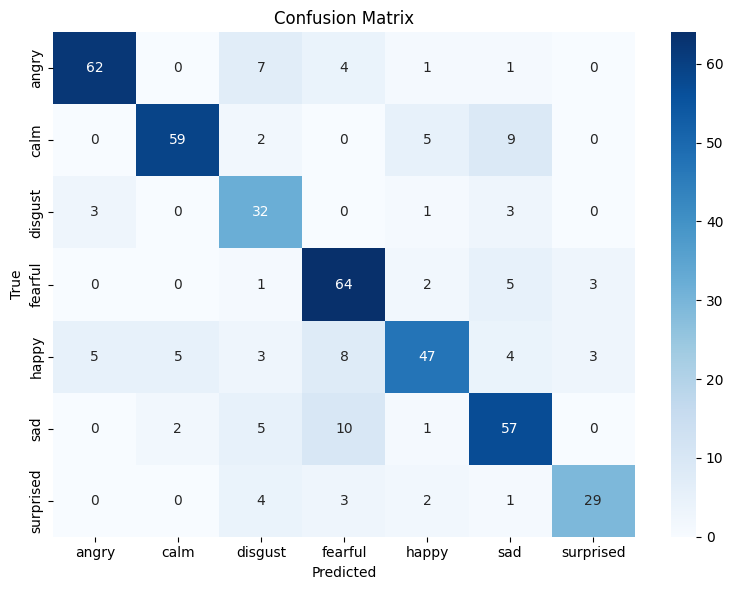

✅ Final Accuracy: 77.26%
✅ Final Macro-Averaged F1 Score: 76.88%


In [118]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predictions
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Accuracy and F1 Score
accuracy = accuracy_score(y_val_enc, y_pred)
macro_f1 = f1_score(y_val_enc, y_pred, average='macro')

# Classification report
print("Classification Report:")
print(classification_report(y_val_enc, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_val_enc, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


print(f"✅ Final Accuracy: {accuracy * 100:.2f}%")
print(f"✅ Final Macro-Averaged F1 Score: {macro_f1 * 100:.2f}%")


In [119]:
model.save("emotion_cnn_mel.h5")

c:\softwares\python 3.8\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [120]:
model.save("emotion_cnn_mel.keras")

In [121]:
import joblib

joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']